In [1]:
import torch
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
tmp = io.loadmat('opt.mat')
radial_tops = tmp['radial_tops']
base_endpoint = tmp['base_endpoint'].transpose()
ileaves = np.shape(radial_tops)[0]
print(base_endpoint.dtype, base_endpoint.shape)
print(radial_tops.dtype, radial_tops.shape)
print(ileaves)
assert base_endpoint.shape == (3,1)

float64 (3, 1)
float64 (2217, 3)
2217


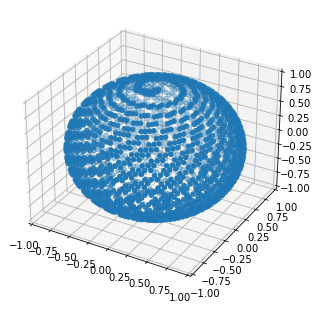

In [98]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(radial_tops[:,0],radial_tops[:,1],radial_tops[:,2])
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
plt.show()

In [96]:
xdir = radial_tops[:,0]
ydir = radial_tops[:,1]
zdir = radial_tops[:,2]
Rshot = torch.zeros(ileaves,3,3,dtype=float)
utu = torch.zeros(ileaves,3,3)
usk = torch.zeros(ileaves,3,3)
base_endpoint = torch.tensor(base_endpoint, dtype=float).squeeze()
for pos in range(ileaves):
    phi = math.acos( zdir[pos] / math.sqrt(xdir[pos]**2 + ydir[pos]**2 + zdir[pos]**2) )
    theta = math.pi/2 + math.atan2( ydir[pos], xdir[pos])
    
    ux = xdir[pos]
    uy = ydir[pos]
    uz = zdir[pos]
    
    Rphi = torch.tensor([[1, 0, 0],
                            [0, math.cos(phi), -math.sin(phi)],
                            [0, math.sin(phi), math.cos(phi)]])
    Rtheta = torch.tensor([[math.cos(theta), -math.sin(theta), 0],
                            [math.sin(theta),  math.cos(theta), 0],
                            [0, 0, 1]])
    
    utu[pos,:,:] = torch.tensor([[ux**2, ux*uy, ux*uz],
                                    [ux*uy, uy**2, uy*uz],
                                    [ux*uz, uy*uz, uz**2]])
    usk[pos,:,:] = torch.tensor([[0, -uz, -uy],
                                    [uz, 0, -ux],
                                    [-uy, ux, 0]])
    Rshot[pos,:,:] = torch.matmul(Rtheta, Rphi)
endpoints = torch.matmul(Rshot, base_endpoint)

/home/fs0/qijia/.conda/envs/pytorch-1.1-cpu_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


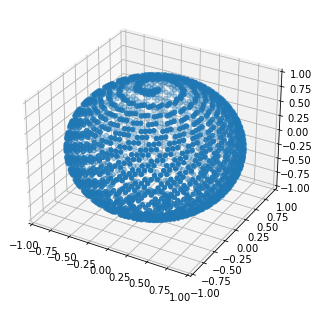

In [100]:
rtop=torch.matmul(Rshot.float(), torch.tensor([0,0,1],dtype=torch.float32))
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rtop[:,0],rtop[:,1],rtop[:,2])
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
plt.show()

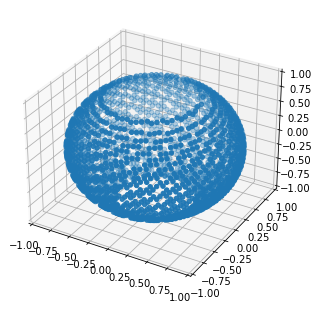

In [97]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(endpoints[:,0],endpoints[:,1],endpoints[:,2])
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
plt.show()

In [6]:
print(endpoints.shape)
print(torch.min(endpoints[:,0]),torch.max(endpoints[:,0]),torch.min(endpoints[:,1]),torch.max(endpoints[:,1]),torch.min(endpoints[:,2]),torch.max(endpoints[:,2]))

torch.Size([2217, 3])
tensor(-0.9990, dtype=torch.float64) tensor(0.9994, dtype=torch.float64) tensor(-0.9995, dtype=torch.float64) tensor(0.9994, dtype=torch.float64) tensor(-0.8851, dtype=torch.float64) tensor(0.8542, dtype=torch.float64)


In [79]:
torch.autograd.set_detect_anomaly(True)
class optimize():
    def __init__(self, ileaves, radial_tops, base_endpoint, max_iter = 1000, lr=0.1):

        self.omega_all = torch.rand(ileaves,requires_grad=True)
        self.optimizer = torch.optim.Adam([self.omega_all],lr=lr)
        # self.lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[20,40, 80, 160], gamma=0.5)
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=30, threshold=1e-4)
        self.max_iter = max_iter
        self.base_endpoint = base_endpoint.float()
        xdir = radial_tops[:,0]
        ydir = radial_tops[:,1]
        zdir = radial_tops[:,2]
        self.ileaves = ileaves
        self.Rshot = torch.zeros(ileaves,3,3)
        self.utu = torch.zeros(ileaves,3,3)
        self.usk = torch.zeros(ileaves,3,3)
        self.R = torch.zeros(ileaves,3,3)
        self.endpoints = torch.zeros(ileaves, 3)
        for pos in range(self.ileaves):
            phi = math.acos( zdir[pos] / math.sqrt(xdir[pos]**2 + ydir[pos]**2 + zdir[pos]**2) )
            theta = math.pi/2 + math.atan2( ydir[pos], xdir[pos])
            
            ux = xdir[pos]
            uy = ydir[pos]
            uz = zdir[pos]
            
            Rphi = torch.tensor([[1, 0, 0],
                                 [0, math.cos(phi), -math.sin(phi)],
                                 [0, math.sin(phi), math.cos(phi)]])
            Rtheta = torch.tensor([[math.cos(theta), -math.sin(theta), 0],
                                   [math.sin(theta),  math.cos(theta), 0],
                                   [0, 0, 1]])
            
            self.utu[pos,:,:] = torch.tensor([[ux*ux, ux*uy, ux*uz],
                                            [ux*uy, uy*uy, uy*uz],
                                            [ux*uz, uy*uz, uz*uz]])
            self.usk[pos,:,:] = torch.tensor([[0, -uz, uy],
                                            [uz, 0, -ux],
                                            [-uy, ux, 0]])
            self.Rshot[pos,:,:] = torch.matmul(Rtheta, Rphi)

    def get_rotation_matrix(self):
        # with torch.no_grad():
        #     print('omega',torch.max(self.omega_all), torch.min(self.omega_all), self.omega_all.shape)
        cosomega = torch.cos(2 * math.pi * self.omega_all.unsqueeze(1).unsqueeze(2))
        sinomega = torch.sin(2 * math.pi * self.omega_all.unsqueeze(1).unsqueeze(2))
        # print(cosomega.shape, cosomega.requires_grad)
        Raxis = self.utu + cosomega * (torch.eye(3).unsqueeze(0) - self.utu) + sinomega * self.usk
        self.R = torch.matmul(Raxis, self.Rshot)
        self.endpoints = torch.matmul(self.R, self.base_endpoint.squeeze())

    def calc_cost(self):
        # with torch.no_grad():
        #     print(self.endpoints.shape)
        #     print(torch.max(self.endpoints),torch.min(self.endpoints))
        tmp = self.endpoints.unsqueeze(1) - self.endpoints.unsqueeze(0)
        dist = torch.sqrt(torch.sum(tmp*tmp, 2)+0.001) + torch.eye(self.ileaves)
        # with torch.no_grad():
        #     print(torch.min(dist),torch.max(dist))
        # tmp = (self.endpoints.unsqueeze(1) - self.endpoints.unsqueeze(0)) * (self.endpoints.unsqueeze(1) - self.endpoints.unsqueeze(0))
        # print(tmp.shape)
        # dists = torch.sum(dist*dist, 2)
        # dist = dist + torch.eye(self.ileaves)
        # with torch.no_grad():
        #     plt.scatter(self.endpoints.numpy()[:,0],self.endpoints.numpy()[:,1])
        #     print(torch.max(dist), torch.min(dist), dist.shape)
        self.cost = torch.sum( 1 / dist ) / (self.ileaves**2)
        # self.cost = torch.sum( dists )

    def optim(self):
        for iter in range(self.max_iter):
            self.get_rotation_matrix()
            self.calc_cost()
            
            # if (self.omega_all.grad is not None):
            #     self.omega_all.grad.data.zero_()
            self.optimizer.zero_grad()
            self.cost.backward()
            with torch.no_grad():
                # print(self.endpoints.grad.data)
                print('iter : ', iter, ' cost = ', self.cost.item())
                # print(self.omega_all.grad.data)
            self.optimizer.step()
            self.lr_scheduler.step(self.cost)
            # with torch.no_grad():
            # self.omega_all = self.omega_all - 0.1 * self.omega_all.grad.data


In [83]:
opt_obj = optimize(ileaves, radial_tops, base_endpoint, lr=1, max_iter=3)
opt_obj.optim()
io.savemat('optR.mat',{'optR':opt_obj.R.detach().numpy()})

iter :  0  cost =  0.9198060035705566
iter :  1  cost =  0.9198351502418518
iter :  2  cost =  0.9188130497932434


In [38]:
def himmelblau(x):  # 利用梯度下降计算这个函数的最小值
    return (x[0] ** 2 + x[1] - 11) ** 2 + (x[0] + x[1] ** 2 - 7) ** 2

#  这里是画函数图


# x = np.arange(-6, 6, 0.1)
# y = np.arange(-6, 6, 0.1)
# print('x,y range:', x.shape, y.shape)
# X, Y = np.meshgrid(x, y)
# print('X,Y maps:', X.shape, Y.shape)
# Z = himmelblau([X, Y])

# fig = plt.figure('himmelblau')
# ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, Z)
# ax.view_init(60, -30)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# plt.show()


# 下面是梯度下降的具体过程
x = torch.tensor([-4., 0.], requires_grad=True)  # 这里x表示的就是自变量x，y。[]里面是初始化的值，需要对x,y求导
optimizer = torch.optim.Adam([x], lr=1e-3)  # 使用Adam编译器，对自变量使用，学习速率：lr=1e-3
for step in range(20000):  # 迭代20000次

    pred = himmelblau(x)  # 预测的值是pred，要使pred达到最小

    optimizer.zero_grad()  # 首先将所有梯度清零
    pred.backward()  # 对pred反向传播，求得x，y每次的梯度
    optimizer.step()  # 这是代表更新一步，在这里面完成了自动利用梯度更新权值。这里是更新x,y

    if step % 2000 == 0:
        print('step {}: x = {}, f(x) = {}'.format(step, x.tolist(), pred.item()))




step 0: x = [-3.999000072479248, -0.0009999999310821295], f(x) = 146.0
step 2000: x = [-3.526559829711914, -2.5002429485321045], f(x) = 19.4503231048584
step 4000: x = [-3.777446746826172, -3.2777843475341797], f(x) = 0.0012130826944485307
step 6000: x = [-3.7793045043945312, -3.283174753189087], f(x) = 5.636138666886836e-09
step 8000: x = [-3.779308319091797, -3.28318190574646], f(x) = 7.248672773130238e-10
step 10000: x = [-3.7793095111846924, -3.28318452835083], f(x) = 8.822098607197404e-11
step 12000: x = [-3.7793102264404297, -3.2831854820251465], f(x) = 8.185452315956354e-12
step 14000: x = [-3.7793102264404297, -3.2831859588623047], f(x) = 0.0
step 16000: x = [-3.7793102264404297, -3.2831859588623047], f(x) = 0.0
step 18000: x = [-3.7793102264404297, -3.2831859588623047], f(x) = 0.0


In [85]:
opt=io.loadmat('optR.mat')
R=opt['optR'].transpose(2,0,1)
endpoints=opt['endpoints']

In [88]:
br=torch.tensor([0,0,1])
ed = torch.matmul(torch.tensor(R), br.float())

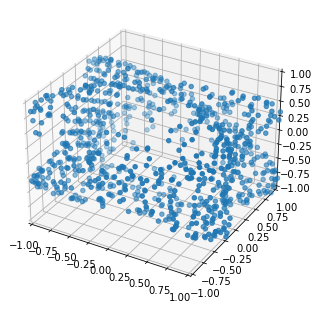

In [89]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(ed[:,0],ed[:,1],ed[:,2])
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
plt.show()

In [95]:
np.sum(radial_tops*radial_tops,1)

array([1., 1., 1., ..., 1., 1., 1.])

In [102]:
torch.sum(ed*ed,1)

tensor([2.2471, 1.0813, 0.6772, 1.7668, 1.9321, 1.2923, 1.0473, 1.3836, 0.9357,
        1.7083, 1.0119, 1.0326, 0.9613, 0.7907, 1.0062, 0.7095, 1.4648, 2.0201,
        1.0583, 1.7653, 2.0346, 0.9203, 0.8929, 0.8657, 1.6015, 1.4404, 1.3759,
        0.9332, 1.8540, 0.9923, 2.1735, 1.0437, 1.1221, 1.3740, 1.8195, 1.1218,
        1.0283, 1.7140, 1.4043, 1.6955, 0.9691, 0.8829, 0.9902, 0.9990, 0.9861,
        1.2515, 1.4043, 1.7853, 1.1820, 0.6292, 1.3884, 1.1628, 1.7461, 0.9633,
        1.2479, 1.4498, 1.3939, 0.9926, 1.5287, 0.9503, 2.1539, 1.2088, 0.9360,
        1.1573, 2.1068, 1.0924, 0.9637, 1.7328, 0.8206, 1.6093, 0.9372, 2.1588,
        1.0375, 1.0786, 0.9028, 1.8926, 1.2533, 1.4960, 1.2504, 0.9657, 1.9965,
        1.4077, 1.8486, 1.1351, 1.0409, 1.0961, 2.1036, 0.9971, 1.1455, 0.9356,
        1.8013, 1.1885, 0.8448, 0.9003, 1.9989, 1.0038, 0.8635, 1.8506, 1.2351,
        1.2844, 0.9941, 1.9190, 1.1980, 1.4340, 1.0790, 1.3398, 0.9669, 2.2358,
        1.5785, 1.1895, 1.8456, 1.4365, 